In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/riyad_workshop

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/riyad_workshop


In [0]:
import pandas as pd

df_tweet = pd.read_csv('tweet-featues.csv')
df_topic = pd.read_csv('topic-features-news.csv')

In [0]:
for tweet_num,sub_tweet in enumerate(df_tweet['Topic_Name']):
  for topic_num,topic in enumerate(df_topic['Topic_Name']):
    if sub_tweet==topic:
      #print (df_topic['Topic_Detection'][topic_num],'----->',topic_num+2)
      if df_topic['Topic_Detection'][topic_num] =='Rumor':
        df_tweet['Topic_Detection'][tweet_num]=1
        break
      else:
        df_tweet['Topic_Detection'][tweet_num]=0
        break     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [0]:
from sklearn import model_selection
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_tweet['tweet_without_EOL'],df_tweet['Topic_Detection'],test_size=0.25,random_state=101)

In [0]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Train_X)
sequences = tok.texts_to_sequences(Train_X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
test_sequences = tok.texts_to_sequences(Test_X)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [0]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [0]:
def NN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Flatten()(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [0]:
model = NN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               1920256   
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [0]:
history =  model.fit(sequences_matrix,Train_Y,batch_size=128,epochs=1,validation_data=(test_sequences_matrix, Test_Y),validation_split=0.2)




Train on 80362 samples, validate on 26788 samples
Epoch 1/1





80362/80362 [==============================] - 40s 498us/step - loss: 0.0482 - acc: 0.9821 - val_loss: 0.0188 - val_acc: 0.9923


In [0]:
model.save('lstm_model.h5')

In [0]:
import pickle
with open('tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
{'val_loss': [0.018787907611782294], 'val_acc': [0.9923099895475586], 'loss': [0.048207102643458455], 'acc': [0.9820810831182614]}


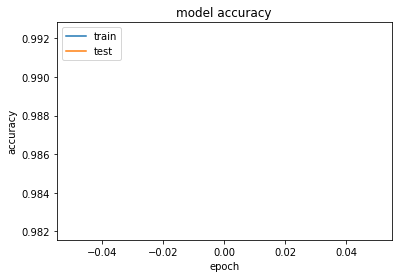

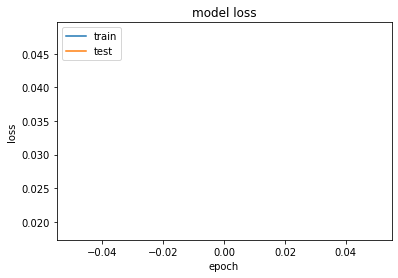

<Figure size 432x288 with 0 Axes>

In [0]:
print(history.history.keys())
# summarize history for accuracy
print (history.history)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('lstm_acc.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('lstm_loss.png')

In [0]:
label = model.predict(test_sequences_matrix,batch_size=32,verbose = 2)

In [0]:
y_hat=[]
for i in label:
  y_hat = np.append(y_hat,np.argmax(i))

In [0]:
from sklearn.metrics import precision_recall_fscore_support
precision,recall,f1_macro,_ = precision_recall_fscore_support(Test_Y,y_hat,average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


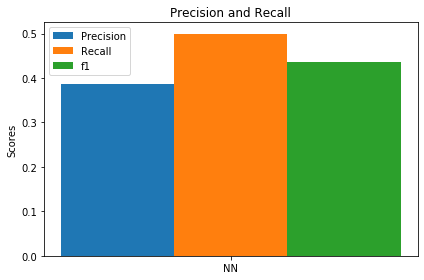

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['NN']
bar1 = [precision]
bar2 = [recall]
bar3 = [f1_macro]

x = np.arange(len(labels))  
width = 0.2 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, bar1, width, label='Precision')
rects2 = ax.bar(x, bar2, width, label='Recall')
rects3 = ax.bar(x + width, bar3, width, label='f1')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()